<a href="https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/verbose/alphafold_noTemplates_noMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#AlphaFold

In [1]:
#################
# WARNING 
#################
# - This notebook is intended as a "quick" demo, it disables many aspects of the full alphafold2 pipeline 
#   (input MSA/templates, amber MD refinement, and number of models). For best results, we recommend using the
#   full pipeline: https://github.com/deepmind/alphafold
# - That being said, it was found that input templates and amber-relax did not help much.
#   The key input features are the MSA (Multiple Sequence Alignment) of related proteins. Where you see a 
#   significant drop in predicted accuracy when MSA < 30, but only minor improvements > 100. 
# - This notebook does NOT include the alphafold2 MSA generation pipeline, and is designed to work with a
#   single sequence, custom MSA input (that you can upload) or MMseqs2 webserver.
# - Single sequence mode is particularly useful for denovo designed proteins (where there are no sequence
#   homologs by definition). For natural proteins, an MSA input will make a huge difference.

#################
# EXTRA
#################
# For other related notebooks see: https://github.com/sokrypton/ColabFold

In [ ]:
# install/import alphafold (and required libs)
import os, sys
if not os.path.isdir("/content/alphafold"):
  %shell git clone -q https://github.com/deepmind/alphafold.git; cd alphafold; git checkout -q 1d43aaff941c84dc56311076b58795797e49107b
  %shell mkdir --parents params; curl -fsSL https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar | tar x -C params
  %shell pip -q install biopython dm-haiku==0.0.5 ml-collections py3Dmol
if '/content/alphafold' not in sys.path:
  sys.path.append('/content/alphafold')

import numpy as np
import py3Dmol
import matplotlib.pyplot as plt

from alphafold.common import protein
from alphafold.data import pipeline
from alphafold.data import templates
from alphafold.model import data
from alphafold.model import config
from alphafold.model import model

In [3]:
# setup which model params to use
# note: for this demo, we only use model 1, for all five models uncomments the others!
model_runners = {}
models = ["model_1"] #,"model_2","model_3","model_4","model_5"]
for model_name in models:
  model_config = config.model_config(model_name)
  model_config.data.eval.num_ensemble = 1
  model_params = data.get_model_haiku_params(model_name=model_name, data_dir=".")
  model_runner = model.RunModel(model_config, model_params)
  model_runners[model_name] = model_runner

In [4]:
def mk_mock_template(query_sequence):
  '''create blank template'''
  ln = len(query_sequence)
  output_templates_sequence = "-"*ln
  templates_all_atom_positions = np.zeros((ln, templates.residue_constants.atom_type_num, 3))
  templates_all_atom_masks = np.zeros((ln, templates.residue_constants.atom_type_num))
  templates_aatype = templates.residue_constants.sequence_to_onehot(output_templates_sequence,templates.residue_constants.HHBLITS_AA_TO_ID)
  template_features = {'template_all_atom_positions': templates_all_atom_positions[None],
                       'template_all_atom_masks': templates_all_atom_masks[None],
                       'template_aatype': np.array(templates_aatype)[None],
                       'template_domain_names': [f'none'.encode()]}
  return template_features

In [5]:
def predict_structure(prefix, feature_dict, model_runners, random_seed=0):  
  """Predicts structure using AlphaFold for the given sequence."""

  # Run the models.
  plddts = {}
  for model_name, model_runner in model_runners.items():
    processed_feature_dict = model_runner.process_features(feature_dict, random_seed=random_seed)
    prediction_result = model_runner.predict(processed_feature_dict)
    unrelaxed_protein = protein.from_prediction(processed_feature_dict,prediction_result)
    unrelaxed_pdb_path = f'{prefix}_unrelaxed_{model_name}.pdb'
    plddts[model_name] = prediction_result['plddt']

    print(f"{model_name} {plddts[model_name].mean()}")

    with open(unrelaxed_pdb_path, 'w') as f:
      f.write(protein.to_pdb(unrelaxed_protein))
  return plddts

# Single sequence input (no MSA)

In [6]:
# Change this line to sequence you want to predict
query_sequence = "GWSTELEKHREELKEFLKKEGITNVEIRIDNGRLEVRVEGGTERLKRFLEELRQKLEKKGYTVDIKIE"

In [7]:
%%time
feature_dict = {
    **pipeline.make_sequence_features(sequence=query_sequence,
                                      description="none",
                                      num_res=len(query_sequence)),
    **pipeline.make_msa_features(msas=[[query_sequence]],
                                 deletion_matrices=[[[0]*len(query_sequence)]]),
    **mk_mock_template(query_sequence)
}
plddts = predict_structure("test",feature_dict,model_runners)

model_1 83.72061105785679
CPU times: user 6min 43s, sys: 10.4 s, total: 6min 54s
Wall time: 4min 44s


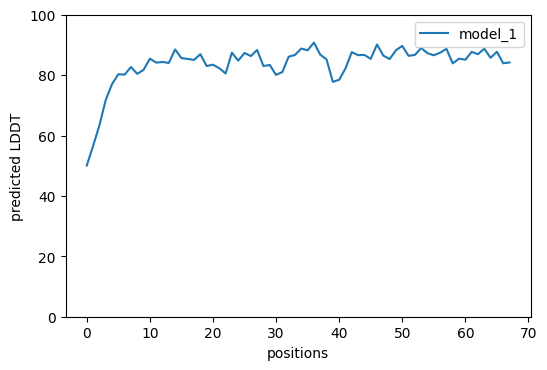

In [8]:
# confidence per position
plt.figure(dpi=100)
for model,value in plddts.items():
  plt.plot(value,label=model)
plt.legend()
plt.ylim(0,100)
plt.ylabel("predicted LDDT")
plt.xlabel("positions")
plt.show()

In [9]:
  p = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
  p.addModel(open("test_unrelaxed_model_1.pdb",'r').read(),'pdb')
  p.setStyle({'cartoon': {'color':'spectrum'}})
  p.zoomTo()
  p.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [10]:
  p = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
  p.addModel(open("test_unrelaxed_model_1.pdb",'r').read(),'pdb')
  p.setStyle({'cartoon': {'color':'spectrum'},'stick':{}})
  p.zoomTo()
  p.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Custom MSA input

In [13]:
%%bash
# for this demo we will download a premade MSA input
wget -qnc --no-check-certificate https://gremlin2.bakerlab.org/db/ECOLI/fasta/P0A8I3.fas

In [14]:
msa, deletion_matrix = pipeline.parsers.parse_a3m("".join(open("P0A8I3.fas","r").readlines()))
query_sequence = msa[0]

In [15]:
%%time
feature_dict = {
    **pipeline.make_sequence_features(sequence=query_sequence,
                                      description="none",
                                      num_res=len(query_sequence)),
    **pipeline.make_msa_features(msas=[msa],deletion_matrices=[deletion_matrix]),
    **mk_mock_template(query_sequence)
}
plddts = predict_structure("yaaa",feature_dict,model_runners)

model_1 97.32114682607497
CPU times: user 8min 20s, sys: 57.6 s, total: 9min 18s
Wall time: 6min 44s


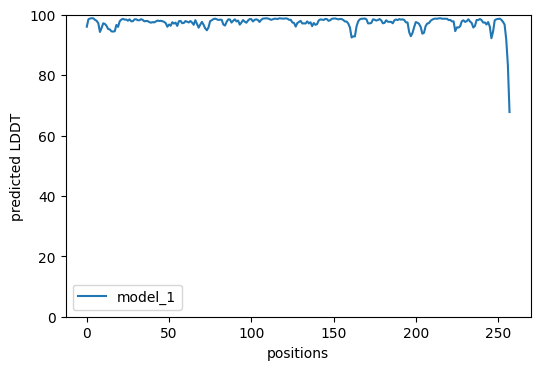

In [16]:
# confidence per position
plt.figure(dpi=100)
for model,value in plddts.items():
  plt.plot(value,label=model)
plt.legend()
plt.ylim(0,100)
plt.ylabel("predicted LDDT")
plt.xlabel("positions")
plt.show()

In [17]:
  p = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
  p.addModel(open("yaaa_unrelaxed_model_1.pdb",'r').read(),'pdb')
  p.setStyle({'cartoon': {'color':'spectrum'}})
  p.zoomTo()
  p.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

#MSA from MMseqs2

In [ ]:
##############################
# Where do I get an MSA?
##############################
# For any "serious" use, I would recommend using the alphafold2 pipeline to make the MSAs, 
# since this is what it was trained on. 

# That being said, part of the MSA generation pipeline (specifically searching against uniprot database using hhblits)
# can be done here: https://toolkit.tuebingen.mpg.de/tools/hhblits
# Alternatively, using the SUPER FAST MMseqs2 pipeline below

# for a HUMAN FRIENDLY version see:
# https://colab.research.google.com/drive/1LVPSOf4L502F21RWBmYJJYYLDlOU2NTL

In [ ]:
%%bash
apt-get -qq -y update 2>&1 1>/dev/null
apt-get -qq -y install jq curl zlib1g gawk 2>&1 1>/dev/null

In [ ]:
# save query sequence to file
name = "YAII"
query_sequence = "MTIWVDADACPNVIKEILYRAAERMQMPLVLVANQSLRVPPSRFIRTLRVAAGFDVADNEIVRQCEAGDLVITADIPLAAEAIEKGAAALNPRGERYTPATIRERLTMRDFMDTLRASGIQTGGPDSLSQRDRQAFAAELEKWWLEVQRSRG"
with open(f"{name}.fasta","w") as out: out.write(f">{name}\n{query_sequence}\n")

In [ ]:
%%bash -s "$name"
# build msa using the MMseqs2 search server
ID=$(curl -s -F q=@$1.fasta -F mode=all https://a3m.mmseqs.com/ticket/msa | jq -r '.id')
STATUS=$(curl -s https://a3m.mmseqs.com/ticket/${ID} | jq -r '.status')
while [ "${STATUS}" == "RUNNING" ]; do
    STATUS=$(curl -s https://a3m.mmseqs.com/ticket/${ID} | jq -r '.status')
    sleep 1
done
if [ "${STATUS}" == "COMPLETE" ]; then
    curl -s https://a3m.mmseqs.com/result/download/${ID}  > $1.tar.gz
    tar xzf $1.tar.gz
    tr -d '\000' < uniref.a3m > $1.a3m
else
    echo "MMseqs2 server did not return a valid result."
    exit 1
fi
echo "Found $(grep -c ">" $1.a3m) sequences (after redundacy filtering)"

Found 3090 sequences (after redundacy filtering)


In [ ]:
msa, deletion_matrix = pipeline.parsers.parse_a3m("".join(open(f"{name}.a3m","r").readlines()))
query_sequence = msa[0]

In [ ]:
%%time
feature_dict = {
    **pipeline.make_sequence_features(sequence=query_sequence,
                                      description="none",
                                      num_res=len(query_sequence)),
    **pipeline.make_msa_features(msas=[msa],deletion_matrices=[deletion_matrix]),
    **mk_mock_template(query_sequence)
}
plddts = predict_structure(name,feature_dict,model_runners)

model_1 91.07940053970414
CPU times: user 2min 24s, sys: 6.47 s, total: 2min 31s
Wall time: 2min 5s


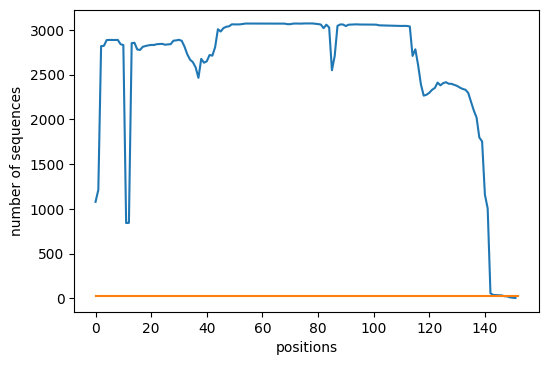

In [ ]:
plt.figure(dpi=100)
plt.plot((feature_dict["msa"] != 21).sum(0))
plt.plot([0,len(query_sequence)],[30,30])
plt.xlabel("positions")
plt.ylabel("number of sequences")
plt.show()

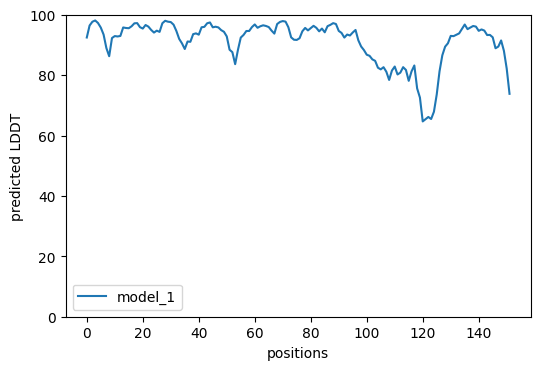

In [ ]:
# confidence per position
plt.figure(dpi=100)
for model,value in plddts.items():
  plt.plot(value,label=model)
plt.legend()
plt.ylim(0,100)
plt.ylabel("predicted LDDT")
plt.xlabel("positions")
plt.show()

In [ ]:
  p = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
  p.addModel(open(f"{name}_unrelaxed_model_1.pdb",'r').read(),'pdb')
  p.setStyle({'cartoon': {'color':'spectrum'}})
  p.zoomTo()
  p.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol